# Emotion-Sentiment-Text
**Kaggle Dataset** - to train a model to recognise emotion in text.

In [15]:
# Importing default Libraries
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
import warnings
from tqdm import tqdm
tqdm.pandas()

# Hi-resolution Plots and Matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Set the maximum number of rows and columns to be displayed
warnings.filterwarnings('ignore')

# "magic commands" to enable autoreload of your imported packages
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
''' Scikit-Learn'''
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix

''' Imbalanced Classes'''
# import imblearn
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.pipeline import Pipeline

''' Tensorflow Keras'''
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf

from transformers import pipeline
from sentence_transformers import SentenceTransformer
import torch

In [3]:
from helper883 import *

In [4]:
data = pd.read_csv('../jan-datasets/emotion_sentimen_dataset.csv')
data.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
data.head()

,text,Emotion
0,i seriously hate one subject to death but now ...,hate
1,im so full of life i feel appalled,neutral
2,i sit here to write i start to dig out my feel...,neutral
3,ive been really angry with r and i feel like a...,anger
4,i feel suspicious if there is no one outside l...,neutral


<Axes: >

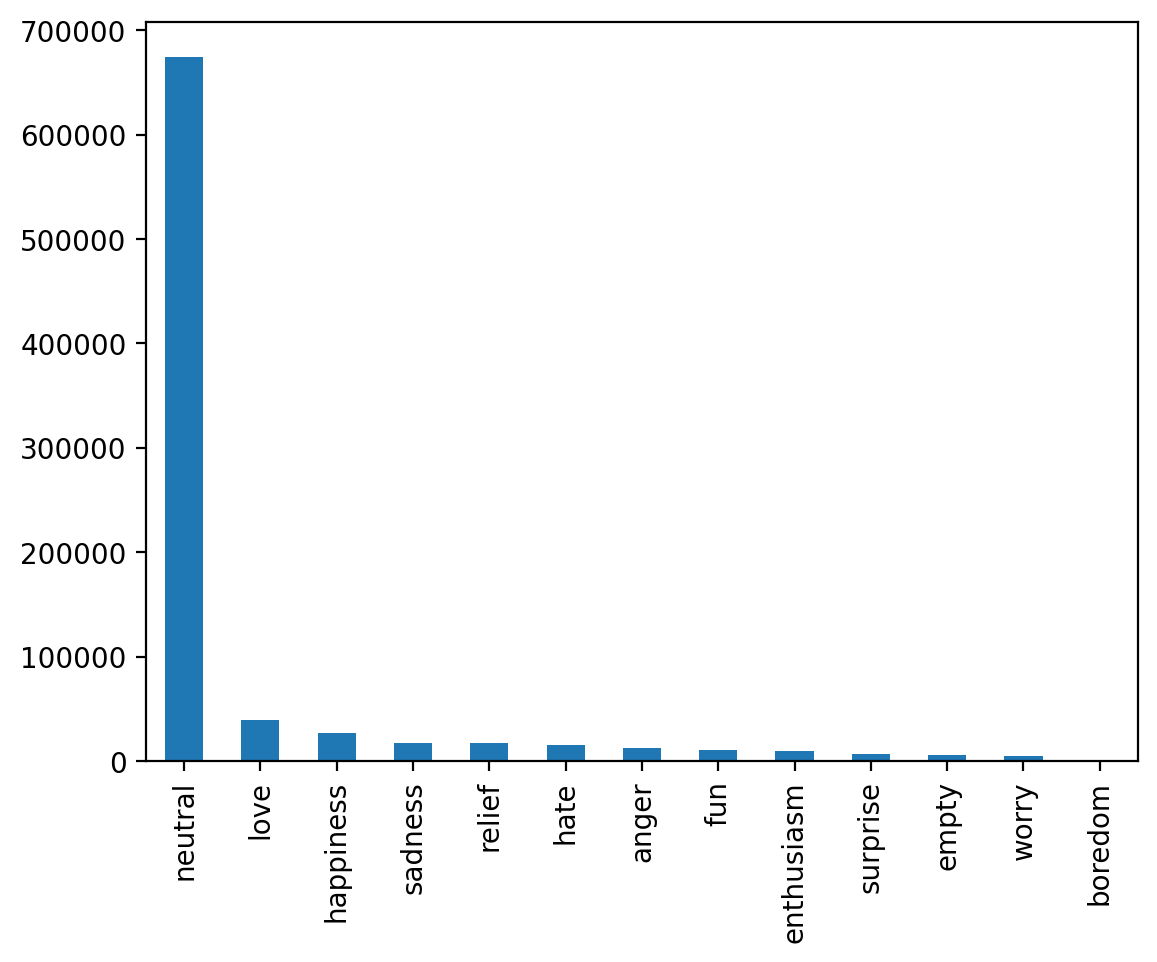

In [6]:
data['Emotion'].value_counts().plot(kind='bar')

In [7]:
for i in data['text'][:10]:
    print(i)
    print(100*'-')

i seriously hate one subject to death but now i feel reluctant to drop it
----------------------------------------------------------------------------------------------------
im so full of life i feel appalled
----------------------------------------------------------------------------------------------------
i sit here to write i start to dig out my feelings and i think that i am afraid to accept the possibility that he might not make it
----------------------------------------------------------------------------------------------------
ive been really angry with r and i feel like an idiot for trusting him in the first place
----------------------------------------------------------------------------------------------------
i feel suspicious if there is no one outside like the rapture has happened or something
----------------------------------------------------------------------------------------------------
i feel jealous becasue i wanted that kind of love the true connection betwee

In [8]:
data["word_count"] = data["text"].apply(lambda x: len(str(x).split()) if isinstance(x, str) else np.nan)

<Axes: xlabel='word_count', ylabel='Count'>

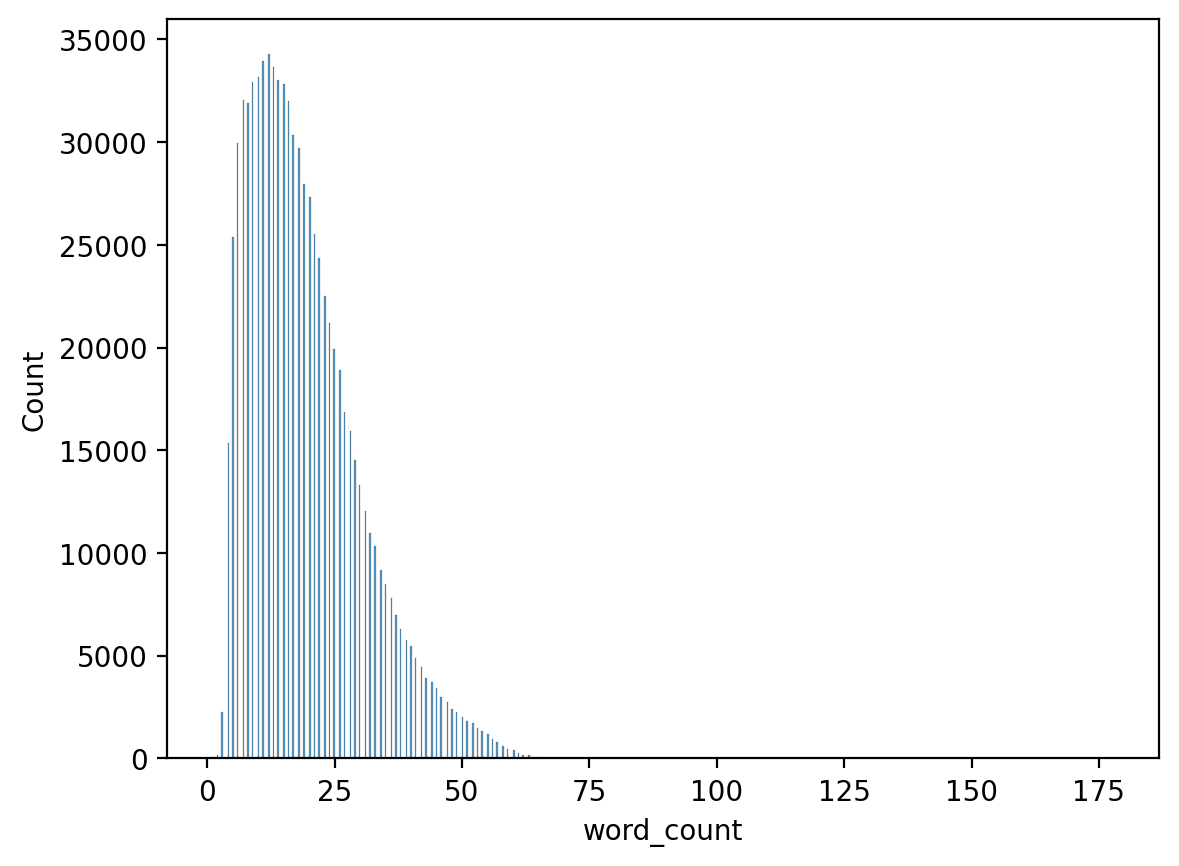

In [9]:
sns.histplot(data['word_count'])

# Create vector representations with Sentence Encoder form Transformers

In [17]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Sentences we want to encode. Example:
sentence = ['This framework generates embeddings for each input sentence']

def embed_sentence(sentence):
    # Sentences are encoded by calling model.encode()
    embedding = model.encode(sentence)
    return embedding

In [ ]:
data['embedding'] = data['text'].progress_apply(embed_sentence)

 97%|███████████████████████████████████████████████████████████▎ | 816925/839555 [2:00:57<03:09, 119.47it/s]

In [ ]:
data.to_csv('../jan-datasets/emotion_sentimen_dataset_embed.csv', index=False)

In [ ]:
X, y = define_X_y(data, target='embedding')

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y, val_size=0.1, test_size=0.1)

# Neural Network

In [ ]:
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred): # defining a custom F1 score metric
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

metrics = [
    keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
    f1_score,  # adding the custom F1 score metric
#     keras.metrics.TruePositives(name='tp'),
#     keras.metrics.FalsePositives(name='fp'),
#     keras.metrics.TrueNegatives(name='tn'),
#     keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
from tensorflow.keras.layers import BatchNormalization, Normalization
from tensorflow.keras.optimizers import Adam


def init_model():
    # Assuming X_train is globally accessible; otherwise, pass it as a parameter.
    # Only take the dimensions of a single sample, excluding the batch size.
    input_shape = X_train.shape[1:]

    model = models.Sequential()

    # Input layer specifying the shape
    model.add(layers.InputLayer(input_shape=input_shape))
    
    # First Dense layer of size 128
    model.add(layers.Dense(128, activation='relu'))
   # model.add(BatchNormalization())
    random_dropout_rate = np.random.uniform(0.3, 0.8)
    model.add(Dropout(random_dropout_rate))
    
        # First Dense layer of size 128
    model.add(layers.Dense(256, activation='relu'))
   # model.add(BatchNormalization())
    random_dropout_rate = np.random.uniform(0.3, 0.8)
    model.add(Dropout(random_dropout_rate))

        # First Dense layer of size 128
    model.add(layers.Dense(256, activation='relu'))
   # model.add(BatchNormalization())
    random_dropout_rate = np.random.uniform(0.3, 0.8)
    model.add(Dropout(random_dropout_rate))
    
        # First Dense layer of size 128
    model.add(layers.Dense(64, activation='relu'))
  # model.add(BatchNormalization())
    random_dropout_rate = np.random.uniform(0.3, 0.8)
    model.add(Dropout(random_dropout_rate))
    
        # First Dense layer of size 128
    model.add(layers.Dense(32, activation='relu'))
  #  model.add(BatchNormalization())
    random_dropout_rate = np.random.uniform(0.3, 0.8)
    model.add(Dropout(random_dropout_rate))

    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Define the initial learning rate
    initial_learning_rate = 0.001

    optimizer = Adam(learning_rate=initial_learning_rate)

    # Assuming 'metrics' is defined globally; otherwise, specify it directly or pass it as a parameter.
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics)

    return model